In [1]:
import pandas as pd
from sklearn.svm import SVC  # "Support Vector Classifier"
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import pickle 

C:\Users\65889\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\65889\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [6]:
df = pd.read_csv("kl_data4.csv")
print(df)

              day   time  temperature   humidity          gas  motion  \
0      2023-11-01   0:00    25.877322  76.955939   775.314644       0   
1      2023-11-01   0:05    25.139135  76.425273   725.094198       0   
2      2023-11-01   0:10    26.843238  77.102513   769.000003       0   
3      2023-11-01   0:15    25.344632  76.212004   724.214364       0   
4      2023-11-01   0:20    26.764051  76.274117   745.743654       0   
...           ...    ...          ...        ...          ...     ...   
12091  2023-12-12  23:35    26.284555  78.988115  1275.484955       0   
12092  2023-12-12  23:40    26.898266  78.694230  1220.091371       0   
12093  2023-12-12  23:45    26.981900  78.042265  1220.869547       0   
12094  2023-12-12  23:50    25.228414  78.670817  1123.801082       0   
12095  2023-12-12  23:55    26.209149  78.045677  1284.652581       0   

          dampness  trash  rating  
0      4095.000000   15.0       5  
1      4095.000000   15.0       5  
2      4095.000

# LSTM Model Test 3

**continue to vary hyperparameters like the number of epochs, number of layers, hidden size, look_back, loss function, optimizer etc. Try to use different method of scaling (min-max scaling instead of z-score normalisation). 

In [7]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

batch_size = 1
look_back = 24 # 2 hours 
hidden_size = 128
num_layers = 2
num_epochs = 100

In [8]:
X = df.iloc[:, 2:-1]
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
print(X.shape)
n_samples = X.shape[0]
X = X.tolist()

time = df.iloc[:, 1]
print(time[288]) # every 288 samples is one day 

X_daily = [] 
i = 0
while i+288 <= n_samples:
    X_daily.append(list(X[i:i+288]))
    i += 288 

print(len(X_daily)) # number of days 
print(len(X_daily[0])) # number of samples in a day

(12096, 6)
0:00
42
288


C:\Users\65889\anaconda3\lib\site-packages\sklearn\utils\validation.py:615: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\65889\anaconda3\lib\site-packages\sklearn\utils\validation.py:615: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [9]:
import pickle
with open('lstm_sc.pkl','wb') as f:
    pickle.dump(sc, f)

In [21]:
# Figure out how many vectors for training and how many for testing.

trainX_all = torch.empty((0, look_back, 6))
trainY_all = torch.empty((0, look_back, 6))
testX_all = torch.empty((0, look_back, 6))
testY_all = torch.empty((0, look_back, 6))

# Generate the datasets with the given look_back.
def create_dataset(dataset, look_back=look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        feature = dataset[i : i + look_back]
        target = dataset[i + 1 :i + look_back + 1]
        dataX.append(feature)
        dataY.append(target)
    return torch.tensor(np.array(dataX)).float(), torch.tensor(np.array(dataY)).float()
    
for dataset in X_daily[:-7]: # 35 days of training data 
    
    trainX, trainY = create_dataset(dataset, look_back)
    
    trainX_all = torch.cat((trainX, trainX_all), 0)
    trainY_all = torch.cat((trainY, trainY_all), 0)

print(trainX_all.shape, trainY_all.shape)

for dataset in X_daily[-7:]: # 7 days of test data 
    
    testX, testY = create_dataset(dataset, look_back)
    
    testX_all = torch.cat((testX, testX_all), 0)
    testY_all = torch.cat((testY, testY_all), 0)
    
print(testX_all.shape, testY_all.shape)

torch.Size([9240, 24, 6]) torch.Size([9240, 24, 6])
torch.Size([1848, 24, 6]) torch.Size([1848, 24, 6])


In [10]:
# Create our LSTM
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 6, hidden_size = hidden_size, num_layers = num_layers, batch_first= True)
        self.output = nn.Linear(hidden_size, 6)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.output(x)
        return x

model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(trainX_all, trainY_all), batch_size = batch_size)
 
for epoch in range(num_epochs):
    model.train()
    for dataX, dataY in loader:
        y = model(dataX)
        loss = loss_fn(y, dataY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(trainX_all)
        train_rmse = np.sqrt(loss_fn(y_pred, trainY_all))
        y_pred = model(testX_all)
        test_rmse = np.sqrt(loss_fn(y_pred, testY_all))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.7410, test RMSE 0.7416
Epoch 1: train RMSE 0.5937, test RMSE 0.5942
Epoch 2: train RMSE 0.5409, test RMSE 0.5420
Epoch 3: train RMSE 0.5107, test RMSE 0.5119
Epoch 4: train RMSE 0.4963, test RMSE 0.4970
Epoch 5: train RMSE 0.4820, test RMSE 0.4828
Epoch 6: train RMSE 0.4391, test RMSE 0.4389
Epoch 7: train RMSE 0.4019, test RMSE 0.4012
Epoch 8: train RMSE 0.3804, test RMSE 0.3783
Epoch 9: train RMSE 0.3433, test RMSE 0.3430
Epoch 10: train RMSE 0.3322, test RMSE 0.3331
Epoch 11: train RMSE 0.3309, test RMSE 0.3317
Epoch 12: train RMSE 0.3259, test RMSE 0.3277
Epoch 13: train RMSE 0.3157, test RMSE 0.3178
Epoch 14: train RMSE 0.3270, test RMSE 0.3272
Epoch 15: train RMSE 0.2999, test RMSE 0.3031
Epoch 16: train RMSE 0.2908, test RMSE 0.2950
Epoch 17: train RMSE 0.2909, test RMSE 0.2970
Epoch 18: train RMSE 0.3009, test RMSE 0.3065
Epoch 19: train RMSE 0.2863, test RMSE 0.2947
Epoch 20: train RMSE 0.2907, test RMSE 0.2977
Epoch 21: train RMSE 0.2817, test RMSE 0.290

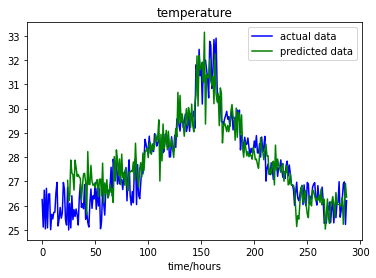

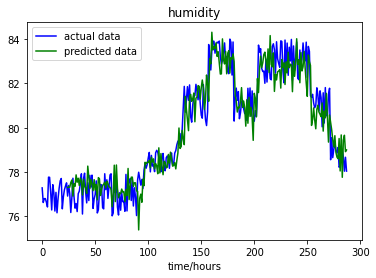

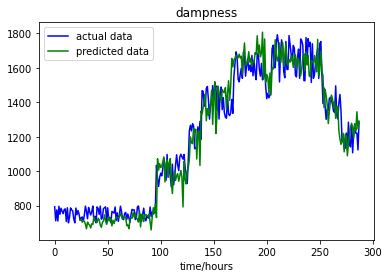

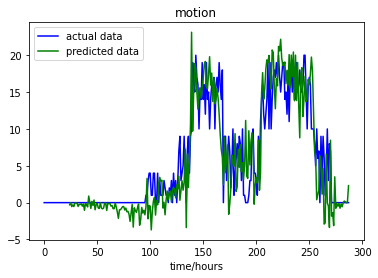

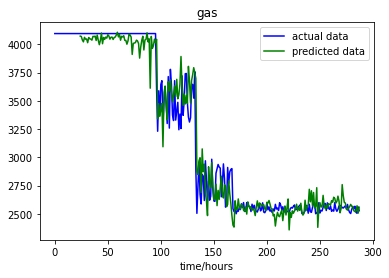

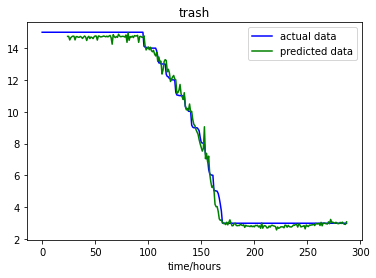

In [22]:
# plot for last test day 
lstm = torch.load('lstm.pth')
lstm.eval()  # Put the model in evaluation model

with torch.no_grad():
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset) * np.nan
    test_plot[look_back:len(dataset)] = lstm(testX)[:, -1, :]
    
test_plot = sc.inverse_transform(test_plot)
dataset = sc.inverse_transform(dataset)

# plot
features = ['temperature', 'humidity', 'dampness', 'motion', 'gas', 'trash']
for n in range(6): 
    test = [i[n] for i in test_plot]
    data = [i[n] for i in dataset]
    plt.plot(data, c='b', label='actual data')
    plt.plot(test, c='g', label='predicted data')
    plt.title(features[n])
    plt.xlabel('time/hours')
    plt.legend()
    
    plt.show()

In [12]:
# save LSTM
model_path = 'lstm.pth'
torch.save(model, model_path)

# Combining this with Classifier (Recursive Forecasting)

In [12]:
test_data = testX[50]
test_data = torch.tensor(np.array(test_data)).float()
print(test_data)

tensor([[-0.6541, -1.8080, -1.1102, -0.8620,  1.1759,  1.1729],
        [-1.1332, -1.5686, -1.2359, -0.8620,  1.1759,  1.1729],
        [-0.7544, -2.1321, -1.2120, -0.8620,  1.1759,  1.1729],
        [-1.0738, -2.0771, -1.2646, -0.8620,  1.1759,  1.1729],
        [-0.7642, -1.7627, -1.1480, -0.8620,  1.1759,  1.1729],
        [-1.4826, -1.6305, -1.1566, -0.8620,  1.1759,  1.1729],
        [-1.3509, -1.6420, -1.1643, -0.8620,  1.1759,  1.1729],
        [-0.7810, -2.0395, -1.1010, -0.8620,  1.1759,  1.1729],
        [-1.0243, -2.0604, -1.2421, -0.8620,  1.1759,  1.1729],
        [-1.2366, -1.4433, -1.1613, -0.8620,  1.1759,  1.1729],
        [-0.8019, -1.7227, -1.2518, -0.8620,  1.1759,  1.1729],
        [-0.8163, -1.5493, -1.1848, -0.8620,  1.1759,  1.1729],
        [-0.7904, -1.8763, -1.0930, -0.8620,  1.1759,  1.1729],
        [-0.8281, -1.6629, -1.1458, -0.8620,  1.1759,  1.1729],
        [-0.7357, -1.4637, -1.2249, -0.8620,  1.1759,  1.1729],
        [-0.3780, -1.4442, -1.2333, -0.8

In [13]:
# Load LSTM
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 6, hidden_size = hidden_size, num_layers = num_layers, batch_first= True)
        self.output = nn.Linear(hidden_size, 6)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.output(x)
        return x
    
lstm = torch.load('lstm.pth')
lstm.eval()  # Put the model in evaluation model 

class ModelNN(nn.Module):
    def __init__(self):
        super(ModelNN, self).__init__()
        self.l1 = nn.Linear(6, 128)
        self.dropout = nn.Dropout(0.1)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 5) # 5 classes: from 1-5

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.dropout(x)
        output = self.l3(x)
        return output
    
classifier = torch.load('classify_nn.pth')
classifier.eval()  # Put the model in evaluation model 

count = 0
with torch.no_grad():
    while True:
        curr = lstm(test_data)
        test_data = curr
        
        outputs = classifier(torch.Tensor(np.array([np.array(curr[-1])])))
        _, predicted = torch.max(outputs.data, 1)
        if (np.array(predicted) < 3): # need to clean (if rating 0, 1, 2)
            break 
            
        count += 1
print("Cleaning is predicted to be required in: " + str(count*5) + " minutes.")

Cleaning is predicted to be required in: 195 minutes.
